# Challenge 3: Artifical Neural Networks

                                   Erion Islamay, Nicola Zucchia, Vittorio Amoruso, Nicola Cortinovis 

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

## 1. Data exploration

### 1.1. Loading the data

In [1]:
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0
torchvision version: 0.15.0


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Setup training data
train_data = datasets.KMNIST(
    root="./data", 
    train=True, 
    download=True, 
    transform=ToTensor(), 
    target_transform=None 
)

# Setup testing data
test_data = datasets.KMNIST(
    root="./data",
    train=False, 
    download=True,
    transform=ToTensor()
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
train_data[0][0].shape # tensor shape

torch.Size([1, 28, 28])

In [6]:
# See classes
class_names = train_data.classes
class_names

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

### 1.2 Visualising the data


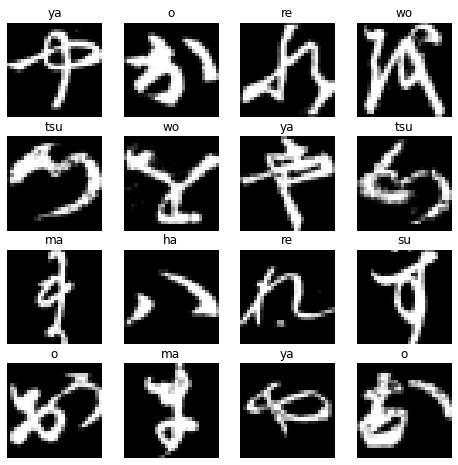

In [7]:
# plot more images 
torch.manual_seed(42) 

fig=plt.figure(figsize=(8, 8))
rows, columns = 4, 4
for i in range(1, rows*columns + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, columns, i)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

### 1.3 Prepare dataloaders

In [8]:
from torch.utils.data import DataLoader

#setup the batch size
BATCH_SIZE = 32

# turn training data into batches
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

#test data into batches
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002AD8B90B670>, <torch.utils.data.dataloader.DataLoader object at 0x000002AD971D3AF0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## 2. Tuning

### Funzioni utili 

Funzioni che verranno usate per il training e il testing dei modelli.

In [9]:

from timeit import default_timer as timer 
import numpy as np
import random


def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)            
            # 1. Forward pass
            test_pred = model(X)            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [11]:
def train_test_model(model, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device):

    train_time_start_on_gpu = timer()


    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        train_step(data_loader=train_dataloader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )
        test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
        )
        
    train_time_end_on_gpu = timer()
    total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


### Fully Connected Neural Networks

#### 2.1.1. Model 1 - 2 hidden layers , sgd optimizer, small layers

In [12]:
class FCNN_2(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units2, out_features=output_shape),
        )
        
    def forward(self, X):
        return self.layer_stack(X)

In [13]:
set_seed(42)

input_size = 784
hidden_size1 = 128
hidden_size2 = 64
num_classes = 10

lr = 0.1
epochs = 5


# instantiate model
Fcnn_2layers_sgd_small = FCNN_2(input_size, hidden_size1, hidden_size2, num_classes).to(device) 
next(Fcnn_2layers_sgd_small.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Fcnn_2layers_sgd_small.parameters(), lr=lr)

# train and test model
train_test_model(Fcnn_2layers_sgd_small, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)


Epoch: 0
---------
Train loss: 0.52263 | Train accuracy: 83.79%
Test loss: 0.58531 | Test accuracy: 81.19%

Epoch: 1
---------
Train loss: 0.21575 | Train accuracy: 93.42%
Test loss: 0.43510 | Test accuracy: 86.79%

Epoch: 2
---------
Train loss: 0.14920 | Train accuracy: 95.41%
Test loss: 0.44992 | Test accuracy: 87.15%

Epoch: 3
---------
Train loss: 0.11216 | Train accuracy: 96.59%
Test loss: 0.41610 | Test accuracy: 88.62%

Epoch: 4
---------
Train loss: 0.08617 | Train accuracy: 97.42%
Test loss: 0.40994 | Test accuracy: 89.06%

Train time on cuda: 56.275 seconds


#### 2.1.2. Model 2 - 2 hidden layers , sgd optimizer, big layers

In [14]:
set_seed(42)

input_size = 784
hidden_size1 = 512
hidden_size2 = 256
num_classes = 10

lr = 0.1
epochs = 5

# instantiate model
Fcnn_2layers_sgd_big = FCNN_2(input_size, hidden_size1, hidden_size2, num_classes).to(device) 
next(Fcnn_2layers_sgd_big.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Fcnn_2layers_sgd_big.parameters(), lr=lr)
# train and test model
train_test_model(Fcnn_2layers_sgd_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.48923 | Train accuracy: 84.86%
Test loss: 0.51718 | Test accuracy: 84.01%

Epoch: 1
---------
Train loss: 0.18475 | Train accuracy: 94.48%
Test loss: 0.43942 | Test accuracy: 86.85%

Epoch: 2
---------
Train loss: 0.11603 | Train accuracy: 96.52%
Test loss: 0.41005 | Test accuracy: 88.46%

Epoch: 3
---------
Train loss: 0.07708 | Train accuracy: 97.75%
Test loss: 0.34374 | Test accuracy: 90.90%

Epoch: 4
---------
Train loss: 0.05086 | Train accuracy: 98.53%
Test loss: 0.35964 | Test accuracy: 90.67%

Train time on cuda: 52.919 seconds


#### 2.1.3. Model 3 - 2 hidden layers , adam optimizer, big layers

In [15]:
set_seed(42)
# Iperparametri
input_size = 784
hidden_size1 = 512
hidden_size2 = 256
num_classes = 10

lr = 0.001
epochs = 5

# instantiate model
Fcnn_2layers_adam_big = FCNN_2(input_size, hidden_size1, hidden_size2, num_classes).to(device) 
next(Fcnn_2layers_adam_big.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Fcnn_2layers_adam_big.parameters(), lr=lr)
# train and test model
train_test_model(Fcnn_2layers_adam_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.32336 | Train accuracy: 89.88%
Test loss: 0.43331 | Test accuracy: 87.06%

Epoch: 1
---------
Train loss: 0.13247 | Train accuracy: 95.96%
Test loss: 0.35457 | Test accuracy: 89.87%

Epoch: 2
---------
Train loss: 0.08081 | Train accuracy: 97.46%
Test loss: 0.35473 | Test accuracy: 90.63%

Epoch: 3
---------
Train loss: 0.05709 | Train accuracy: 98.19%
Test loss: 0.35696 | Test accuracy: 91.34%

Epoch: 4
---------
Train loss: 0.03903 | Train accuracy: 98.71%
Test loss: 0.50492 | Test accuracy: 90.00%

Train time on cuda: 56.555 seconds


#### 2.1.4. Model 4 - 3 hidden layers , adam optimizer, small layers

In [16]:
class FCNN_3(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, hidden_units3: int, output_shape: int, dropout_p: float):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(dropout_p),  # dropout after first ReLU
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(dropout_p),  # dropout after second ReLU
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(dropout_p),  # dropout after third ReLU
            nn.Linear(in_features=hidden_units3, out_features=output_shape),
        )
        
    def forward(self, X):
        return self.layer_stack(X)


In [17]:
set_seed(42)

input_size = 784
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
num_classes = 10
dropout = 0

lr = 0.001
epochs = 5  

# instantiate model
Fcnn_3layers_adam_small = FCNN_3(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout).to(device) 
next(Fcnn_3layers_adam_small.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Fcnn_3layers_adam_small.parameters(), lr=lr)
# train and test model
train_test_model(Fcnn_3layers_adam_small, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.47817 | Train accuracy: 85.37%
Test loss: 0.57961 | Test accuracy: 82.22%

Epoch: 1
---------
Train loss: 0.22241 | Train accuracy: 93.24%
Test loss: 0.52427 | Test accuracy: 84.42%

Epoch: 2
---------
Train loss: 0.15337 | Train accuracy: 95.31%
Test loss: 0.45368 | Test accuracy: 87.15%

Epoch: 3
---------
Train loss: 0.11587 | Train accuracy: 96.40%
Test loss: 0.39640 | Test accuracy: 89.64%

Epoch: 4
---------
Train loss: 0.09239 | Train accuracy: 97.16%
Test loss: 0.40619 | Test accuracy: 89.46%

Train time on cuda: 57.680 seconds


#### 2.1.5. Model 5 - 3 hidden layers , sgd optimizer, big layers

In [18]:
set_seed(42)

input_size = 784
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
num_classes = 10
dropout = 0.25

lr = 0.001
epochs = 5  

# instantiate model
Fcnn_3layers_sgd_big = FCNN_3(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes,dropout).to(device) 
next(Fcnn_3layers_sgd_big.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Fcnn_3layers_sgd_big.parameters(), lr=lr)
# train and test model
train_test_model(Fcnn_3layers_sgd_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.43290 | Train accuracy: 86.67%
Test loss: 0.48807 | Test accuracy: 84.66%

Epoch: 1
---------
Train loss: 0.15513 | Train accuracy: 95.39%
Test loss: 0.43879 | Test accuracy: 87.49%

Epoch: 2
---------
Train loss: 0.10060 | Train accuracy: 96.91%
Test loss: 0.35829 | Test accuracy: 90.71%

Epoch: 3
---------
Train loss: 0.07102 | Train accuracy: 97.77%
Test loss: 0.37017 | Test accuracy: 90.94%

Epoch: 4
---------
Train loss: 0.05627 | Train accuracy: 98.28%
Test loss: 0.42461 | Test accuracy: 89.90%

Train time on cuda: 60.512 seconds


#### 2.1.6. Model 6 - 3 hidden layers , adam optimizer, big layers + dropout

In [19]:
set_seed(42)

input_size = 784
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
num_classes = 10
dropout = 0.5

lr = 0.001
epochs = 5


# instantiate model
Fcnn_3layers_adam_big = FCNN_3(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout).to(device) 
next(Fcnn_3layers_adam_big.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Fcnn_3layers_adam_big.parameters(), lr=lr)

train_test_model(Fcnn_3layers_adam_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.60447 | Train accuracy: 81.44%
Test loss: 0.56453 | Test accuracy: 82.34%

Epoch: 1
---------
Train loss: 0.17869 | Train accuracy: 94.61%
Test loss: 0.46204 | Test accuracy: 86.57%

Epoch: 2
---------
Train loss: 0.11417 | Train accuracy: 96.60%
Test loss: 0.40520 | Test accuracy: 89.25%

Epoch: 3
---------
Train loss: 0.08153 | Train accuracy: 97.50%
Test loss: 0.34863 | Test accuracy: 90.62%

Epoch: 4
---------
Train loss: 0.05898 | Train accuracy: 98.15%
Test loss: 0.47367 | Test accuracy: 89.56%

Train time on cuda: 60.900 seconds


Sembra esserci una tendenza all'overfitting per le FNN.

### Convolutional Neural Networks

#### 2.2.1. Model 1 - 2 hidden layers , sgd optimizer, small layers

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_2(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, output_shape: int):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_units1, hidden_units2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_units2 * 14 * 14, output_shape)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

    def forward(self, X):
        #X = self.pool(F.relu(self.conv1(X)))
        X = F.relu(self.conv1(X))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.flatten(X)
        X = self.fc(X)
        return X



In [21]:
set_seed(42)

input_size = 1
hidden_size1 = 32
hidden_size2 = 64
num_classes = 10

lr = 0.1
epochs = 5 

# instantiate model
cnn_2layers_sgd_small = CNN_2(input_size, hidden_size1, hidden_size2, num_classes).to(device) 
next(cnn_2layers_sgd_small.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=cnn_2layers_sgd_small.parameters(), lr=lr)
# train and test model
train_test_model(cnn_2layers_sgd_small, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.33724 | Train accuracy: 89.93%
Test loss: 0.43283 | Test accuracy: 87.60%

Epoch: 1
---------
Train loss: 0.13539 | Train accuracy: 96.09%
Test loss: 0.34193 | Test accuracy: 90.21%

Epoch: 2
---------
Train loss: 0.09155 | Train accuracy: 97.31%
Test loss: 0.30334 | Test accuracy: 91.61%

Epoch: 3
---------
Train loss: 0.06568 | Train accuracy: 98.06%
Test loss: 0.32231 | Test accuracy: 91.79%

Epoch: 4
---------
Train loss: 0.04734 | Train accuracy: 98.58%
Test loss: 0.34077 | Test accuracy: 91.72%

Train time on cuda: 73.206 seconds


#### 2.2.2. Model 2 - 2 hidden layers , adam optimizer, small layers

In [22]:
set_seed(42)

input_size = 1
hidden_size1 = 32
hidden_size2 = 64
num_classes = 10

lr = 0.001
epochs = 5

# instantiate model
cnn_2layers_adam_small = CNN_2(input_size, hidden_size1, hidden_size2, num_classes).to(device) 
next(cnn_2layers_sgd_small.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_2layers_adam_small.parameters(), lr=lr)
# train and test model
train_test_model(cnn_2layers_adam_small, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.27409 | Train accuracy: 92.02%
Test loss: 0.35345 | Test accuracy: 89.79%

Epoch: 1
---------
Train loss: 0.10763 | Train accuracy: 96.83%
Test loss: 0.34592 | Test accuracy: 90.40%

Epoch: 2
---------
Train loss: 0.06733 | Train accuracy: 98.08%
Test loss: 0.30095 | Test accuracy: 92.08%

Epoch: 3
---------
Train loss: 0.04314 | Train accuracy: 98.70%
Test loss: 0.31502 | Test accuracy: 92.51%

Epoch: 4
---------
Train loss: 0.02784 | Train accuracy: 99.12%
Test loss: 0.33068 | Test accuracy: 92.79%

Train time on cuda: 75.004 seconds


#### 2.2.2. Model 3 - 2 hidden layers , adam optimizer, big layers

In [23]:
set_seed(42)

input_size = 1
hidden_size1 = 64
hidden_size2 = 128
num_classes = 10

lr = 0.001
epochs = 5

# instantiate model
cnn_2layers_adam_big = CNN_2(input_size, hidden_size1, hidden_size2, num_classes).to(device) 
next(cnn_2layers_adam_big.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_2layers_adam_big.parameters(), lr=lr)
# train and test model
train_test_model(cnn_2layers_adam_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.22690 | Train accuracy: 93.33%
Test loss: 0.30285 | Test accuracy: 91.42%

Epoch: 1
---------
Train loss: 0.08191 | Train accuracy: 97.62%
Test loss: 0.28785 | Test accuracy: 92.53%

Epoch: 2
---------
Train loss: 0.04342 | Train accuracy: 98.65%
Test loss: 0.29142 | Test accuracy: 92.92%

Epoch: 3
---------
Train loss: 0.02659 | Train accuracy: 99.07%
Test loss: 0.29834 | Test accuracy: 93.15%

Epoch: 4
---------
Train loss: 0.01623 | Train accuracy: 99.44%
Test loss: 0.41198 | Test accuracy: 92.84%

Train time on cuda: 114.610 seconds


#### 2.2.4. Model 4 - 3 hidden layers , adam optimizer, small layers

In [24]:
class CNN_3(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, hidden_units3: int, output_shape: int):
        super(CNN_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_units1, hidden_units2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_units2, hidden_units3, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_units3 * 3 * 3, output_shape)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.flatten(X)
        X = self.fc(X)
        return X


In [25]:
set_seed(42)

input_size = 1
hidden_size1 = 16
hidden_size2 = 32
hidden_size3 = 64
num_classes = 10

lr = 0.001
epochs = 5

# instantiate model
cnn_3layers_adam_big = CNN_3(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device) 
next(cnn_2layers_sgd_small.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_3layers_adam_big.parameters(), lr=lr)
# train and test model
train_test_model(cnn_3layers_adam_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.36618 | Train accuracy: 88.58%
Test loss: 0.39233 | Test accuracy: 87.60%

Epoch: 1
---------
Train loss: 0.12259 | Train accuracy: 96.30%
Test loss: 0.27429 | Test accuracy: 92.21%

Epoch: 2
---------
Train loss: 0.08453 | Train accuracy: 97.45%
Test loss: 0.25084 | Test accuracy: 93.23%

Epoch: 3
---------
Train loss: 0.06111 | Train accuracy: 98.17%
Test loss: 0.26872 | Test accuracy: 92.79%

Epoch: 4
---------
Train loss: 0.04825 | Train accuracy: 98.55%
Test loss: 0.23195 | Test accuracy: 94.23%

Train time on cuda: 65.890 seconds


#### 2.2.5. Model 5 - 3 hidden layers , adam optimizer, big layers

In questo modello raddoppiamo il numero di filtri per ogni layer convoluzionale.

In [26]:
class CNN_4(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, hidden_units3: int, output_shape: int, dropout: float):
        super(CNN_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=hidden_units1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_units1, hidden_units2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_units2, hidden_units3, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_units3 * 3 * 3, output_shape)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout) # Dropout with a probability of 0.5

    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.flatten(X)
        X = self.dropout(X)
        X = self.fc(X)
        return X

In [27]:
set_seed(42)

input_size = 1
hidden_size1 = 32
hidden_size2 = 64
hidden_size3 = 128
num_classes = 10
dropout = 0

lr = 0.001
epochs = 5

# instantiate model
cnn_3layers_adam_big = CNN_4(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout).to(device) 
next(cnn_2layers_sgd_small.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_3layers_adam_big.parameters(), lr=lr)
# train and test model
train_test_model(cnn_3layers_adam_big, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device)

Epoch: 0
---------
Train loss: 0.26179 | Train accuracy: 91.86%
Test loss: 0.29819 | Test accuracy: 91.11%

Epoch: 1
---------
Train loss: 0.07731 | Train accuracy: 97.66%
Test loss: 0.23497 | Test accuracy: 93.26%

Epoch: 2
---------
Train loss: 0.04914 | Train accuracy: 98.49%
Test loss: 0.24404 | Test accuracy: 94.14%

Epoch: 3
---------
Train loss: 0.03523 | Train accuracy: 98.91%
Test loss: 0.23028 | Test accuracy: 94.30%

Epoch: 4
---------
Train loss: 0.02639 | Train accuracy: 99.13%
Test loss: 0.22638 | Test accuracy: 95.21%

Train time on cuda: 73.108 seconds


#### 2.2.6. Model 6 - 3 hidden layers , adam optimizer, big layers + dropout

In questo modello raddoppimao ulteriormente il numero di filtri per ogni layer convoluzionale e aggiungiamo un layer di dropout.

Funzioni utili per il plot dei risultati.

In [28]:
def print_train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * X.size(0)
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) * X.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader.dataset)
    train_acc /= len(data_loader.dataset)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def print_test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y).item() * X.size(0)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)) * X.size(0)

    test_loss /= len(data_loader.dataset)
    test_acc /= len(data_loader.dataset)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc


def print_train_test_model(model, train_dataloader, test_dataloader, epochs, loss_fn, optimizer, device):
    #Trains and tests a PyTorch model
    train_time_start_on_gpu = timer()

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        train_loss, train_acc = print_train_step(data_loader=train_dataloader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )
        test_loss, test_acc = print_test_step(data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        
    train_time_end_on_gpu = timer()
    total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [29]:

set_seed(42)

input_size = 1
hidden_size1 = 64
hidden_size2 = 128
hidden_size3 = 256
num_classes = 10
dropout = 0.5

lr = 0.001
epochs = 5

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# instantiate model
cnn_3layers_adam_big_drop = CNN_4(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout).to(device) 
next(cnn_3layers_adam_big_drop.parameters()).device # check model device

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn_3layers_adam_big_drop.parameters(), lr=lr)
# train and test model

train_losses, train_accuracies, test_losses, test_accuracies = print_train_test_model(cnn_3layers_adam_big_drop,
                                                                                      train_dataloader,
                                                                                      test_dataloader,
                                                                                      epochs,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      device)


Epoch: 0
---------
Train loss: 0.28240 | Train accuracy: 91.14%
Test loss: 0.25345 | Test accuracy: 92.82%

Epoch: 1
---------
Train loss: 0.05841 | Train accuracy: 98.27%
Test loss: 0.19357 | Test accuracy: 94.69%

Epoch: 2
---------
Train loss: 0.03622 | Train accuracy: 98.87%
Test loss: 0.23293 | Test accuracy: 93.93%

Epoch: 3
---------
Train loss: 0.02532 | Train accuracy: 99.16%
Test loss: 0.19635 | Test accuracy: 95.32%

Epoch: 4
---------
Train loss: 0.01663 | Train accuracy: 99.51%
Test loss: 0.18224 | Test accuracy: 96.29%

Train time on cuda: 97.530 seconds


## 3. Plotting results of last model

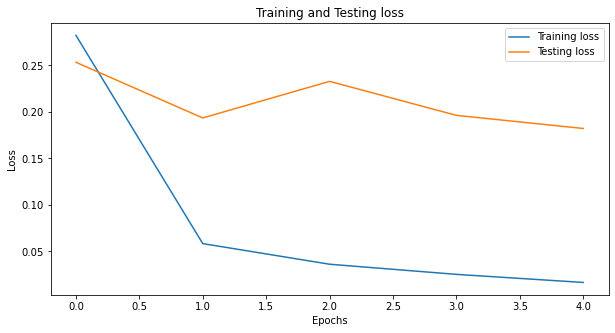

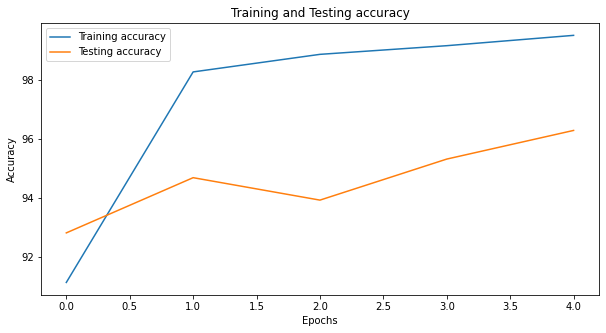

In [30]:
import matplotlib.pyplot as plt

# Plotting the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_losses), label='Training loss')
plt.plot(np.array(test_losses), label='Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(train_accuracies), label='Training accuracy')
plt.plot(np.array(test_accuracies), label='Testing accuracy')
plt.title('Training and Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()